# Обучение модели классификации комментариев

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score

import re 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.utils import shuffle

from tqdm import notebook
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Подготовка

In [2]:
# загрузка данных
import os

pth1 = 'toxic_comments.csv' # Локальный путь
pth2 = '/datasets/toxic_comments.csv' # Сервесный путь 

if os.path.exists(pth1):
    comments = pd.read_csv(pth1)
elif os.path.exists(pth2):
    comments = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# приведем текст к нижнему регистру
comments['text'] = comments['text'].str.lower()

Так как данных много и обработка всего датасета может занять большое количесво времени. Сразу посмотрим на баланс классов

In [7]:
# посмотрим на сбалансированность классов в данных
class_frequency = comments['toxic'].value_counts(normalize=True)
#class_frequency = comments['toxic'].value_counts()
class_frequency

0    0.898321
1    0.101679
Name: toxic, dtype: float64

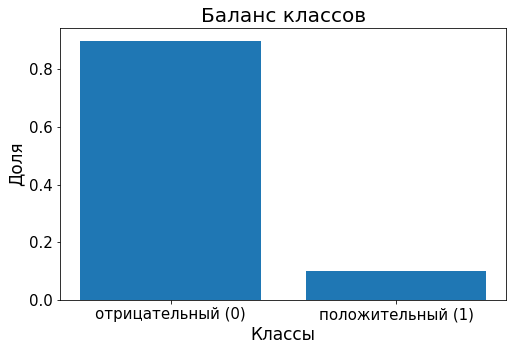

In [8]:
plt.figure(figsize=[8, 5])
ticks_label = ['отрицательный (0)','положительный (1)']

plt.bar(ticks_label, class_frequency)

plt.xticks(ticks_label, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Баланс классов', fontsize=20)
plt.xlabel('Классы', fontsize=17)
plt.ylabel('Доля', fontsize=17)

plt.show()

Разделим данные на обучающую, валидационную и тестовую выборки

In [9]:
# выделим тестовую выборку
df_train, df_test = train_test_split(comments, test_size=0.2, random_state=12345)

# выделим обучающую и валидационную выборки
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=12345)

In [10]:
print('Размер обучающей выборки:', df_train.shape)
print('Размер валидационной выборки:', df_valid.shape)
print('Размер тестовой выборки:', df_test.shape)

Размер обучающей выборки: (95742, 2)
Размер валидационной выборки: (31914, 2)
Размер тестовой выборки: (31915, 2)


**Лемматизируем и очистим текст**

In [19]:
# лематизация
def lemmatize(text):
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Tokenize: Split the sentence into words
    word_list = nltk.word_tokenize(text)
    # Lemmatize list of words and join
    lemm_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        
    return lemm_text

In [20]:
# отчистка
def clear_text(text):
    pattern = r'[^a-zA-z ]'
    replacement = ' '
    clear_text = re.sub(pattern, replacement, text) 

    clear_text = clear_text.split() 

    clear_text = " ".join(clear_text) 
    
    return clear_text

In [21]:
tqdm.pandas()

df_train['lemm_text'] = df_train['text'].progress_apply(lambda x: lemmatize(clear_text(x)))

100%|██████████| 95742/95742 [00:50<00:00, 1905.19it/s]


In [22]:
tqdm.pandas()

df_valid['lemm_text'] = df_valid['text'].progress_apply(lambda x: lemmatize(clear_text(x)))

100%|██████████| 31914/31914 [00:16<00:00, 1882.20it/s]


In [23]:
tqdm.pandas()

df_test['lemm_text'] = df_test['text'].progress_apply(lambda x: lemmatize(clear_text(x)))

100%|██████████| 31915/31915 [00:16<00:00, 1952.09it/s]


In [24]:
df_train.head()

,text,toxic,lemm_text
3180,this person needs reporting to the administrat...,0,this person need reporting to the administrato...
134113,issues addressed \n\ni'm just going to outline...,0,issue addressed i m just going to outline the ...
54472,red pepper cases \n\nred pepper cases\n\nred p...,0,red pepper case red pepper case red pepper wat...
29333,"alpha-bits are back in 2008, they are being so...",0,alpha bit are back in they are being sold a of...
13869,you dumb ass!!\nwhy the fuck would you delete ...,1,you dumb as why the fuck would you delete the ...


Разделим данные на обучающую и тестовую выборки

In [26]:
corpus_train = list(df_train['lemm_text'])
corpus_valid = list(df_valid['lemm_text'])
corpus_test = list(df_test['lemm_text'])

In [27]:
# Преобразуем корпус текстов в мешок слов
stopwords = set(nltk_stopwords.words('english'))


In [28]:
#Создадим матрицу cо значениями TF-IDF
count_tf_idf = TfidfVectorizer(min_df=1,stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

In [29]:
print("Размер матрицы TF-IDF для обучающей выборки:", tf_idf_train.shape)
print("Размер матрицы TF-IDF для валидационной выборки:", tf_idf_valid.shape)
print("Размер матрицы TF-IDF для тестовой выборки:", tf_idf_test.shape)

Размер матрицы TF-IDF для обучающей выборки: (95742, 119209)
Размер матрицы TF-IDF для валидационной выборки: (31914, 119209)
Размер матрицы TF-IDF для тестовой выборки: (31915, 119209)


## Обучение

In [30]:
# DecisionTreeClassifier
def best_papameters_tree(features_train,target_train,features_valid,target_valid):
    best_model_tree = None
    best_f1_tree = 0
    best_depth_tree = 0
    for depth in range(1, 21, 5):
        print(depth)
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth,class_weight="balanced")
        model_tree.fit(features_train,target_train)
        predictions_tree = model_tree.predict(features_valid)
        f1_tree = f1_score(target_valid, predictions_tree)
        if f1_tree > best_f1_tree:
            best_model_tree = model_tree
            best_f1_tree = f1_tree
            best_depth_tree = depth
    return best_depth_tree

In [88]:
best_depth_tree = best_papameters_tree(tf_idf_train, df_train['toxic'],
                                       tf_idf_valid, df_valid['toxic'])

model_tree = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_tree,class_weight="balanced")
model_tree.fit(tf_idf_train, df_train['toxic'])
predictions_tree = model_tree.predict(tf_idf_test)

1
6
11
16


In [89]:
# RandomForestClassifier
def best_papameters_forest(features_train,target_train,features_valid,target_valid):
    best_model_forest = None
    best_f1_forest = 0
    best_est_forest = 0
    best_depth_forest = 0
    for est in range(1, 102, 50):
        for depth in range (1, 22,10):
            print(est, depth)
            model_forest = RandomForestClassifier(random_state=12345, n_estimators=est,max_depth=depth,class_weight="balanced")
            model_forest.fit(features_train,target_train)
            predictions_forest = model_forest.predict(features_valid)
            f1_forest = f1_score(target_valid, predictions_forest)
            if f1_forest > best_f1_forest:
                best_model_forest = model_forest
                best_f1_forest = f1_forest
                best_est_forest = est
                best_depth_forest = depth
    return best_depth_forest,best_est_forest

In [90]:
best_depth_forest,best_est_forest = best_papameters_forest(tf_idf_train, df_train['toxic'],
                                                           tf_idf_valid, df_valid['toxic'])

model_forest = RandomForestClassifier(random_state=12345,
                                      n_estimators=best_est_forest,
                                      max_depth=best_depth_forest,class_weight="balanced")

model_forest.fit(tf_idf_train, df_train['toxic'])
predictions_forest = model_forest.predict(tf_idf_test)

1 1
1 11
1 21
51 1
51 11
51 21
101 1
101 11
101 21


In [31]:
# LogisticRegression
model_log = LogisticRegression(max_iter=200,C=2.5,random_state=12345,class_weight="balanced")
model_log.fit(tf_idf_train, df_train['toxic'])
predictions_log = model_log.predict(tf_idf_test)

In [32]:
f1_score(df_test['toxic'], predictions_log)

0.7578450430435989

In [92]:
# CatBoostClassifier
model_cat = CatBoostClassifier(loss_function= 'Logloss', 
                               iterations=300,
                               eval_metric='F1',
                               random_state=12345)
model_cat.fit(tf_idf_train,df_train['toxic'], verbose=50)
predictions_cat = model_cat.predict(tf_idf_test)

Learning rate set to 0.217944
0:	learn: 0.3710665	total: 2.31s	remaining: 11m 32s
50:	learn: 0.6552004	total: 1m 34s	remaining: 7m 39s
100:	learn: 0.7212341	total: 3m 2s	remaining: 5m 58s
150:	learn: 0.7488937	total: 4m 29s	remaining: 4m 26s
200:	learn: 0.7643015	total: 5m 58s	remaining: 2m 56s
250:	learn: 0.7785944	total: 7m 30s	remaining: 1m 27s
299:	learn: 0.7888393	total: 8m 54s	remaining: 0us


In [93]:
f1_tree   = f1_score(df_test['toxic'], predictions_tree)
f1_forest = f1_score(df_test['toxic'], predictions_forest)
f1_log    = f1_score(df_test['toxic'], predictions_log)
f1_cat    = f1_score(df_test['toxic'], predictions_cat)

In [94]:
print("F1-мера моделей на тестовой выборке:")

print("\"дерево решений\":\t", f1_tree, 
      "Глубина дерева:\t", best_depth_tree)

print("\"случайный лес\":\t", f1_forest, 
      "Количество деревьев:", best_est_forest, 
      "Максимальная глубина:\t", best_depth_forest)

print("\"логическая регрессия\":\t", f1_log)

print("\"cat boost\":\t", f1_cat)

F1-мера моделей на тестовой выборке:
"дерево решений":	 0.5850392194375359 Глубина дерева:	 16
"случайный лес":	 0.3960233218717298 Количество деревьев: 51 Максимальная глубина:	 21
"логическая регрессия":	 0.7578450430435989
"cat boost":	 0.746177370030581


In [95]:
#score_tabel
score_table = {
    'model':['logistic_regression', 'desidion_tree', 'random_forest','cat_boost'],
    'f1_score_test':[f1_log, f1_tree, f1_forest, f1_cat]
}
df_score_table = pd.DataFrame(score_table)
df_score_table.set_index('model',inplace=True)
df_score_table

,f1_score_test
model,
logistic_regression,0.757845
desidion_tree,0.585039
random_forest,0.396023
cat_boost,0.746177


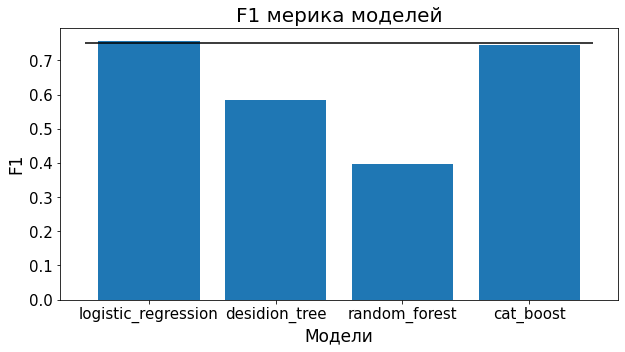

In [96]:
# устанавливаем параметры рисунка
plt.figure(figsize=[10, 5])

# Рисуем столбчатую диаграму

plt.bar(df_score_table.index, df_score_table['f1_score_test'])

plt.hlines(0.75, -0.5, 3.5, color = 'black')

# Добавляем подписи
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('F1 мерика моделей', fontsize=20)
plt.xlabel('Модели', fontsize=17)
plt.ylabel('F1', fontsize=17)

plt.show()

## Выводы

Для предсказания токсичности комментариев были обучены и проанализированы несколько моделей машинного обучения:
- Решающее дерево
- Линейная регрессия
- Случайный лес
- Градиентный бустинг библиотеки CatBoost

Модели сравнивались по метрике F1.

Наилучший результат показала модель логической регрессии.

    F1 = 0.757
    
Для остальных моделей метрика F1 ниже порогового значения (0.75).
